## Amazon Customer Reviews Sentiment Analysis

In [1]:
#Importing the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nabinagahatraj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Load the dataset
data= pd.read_csv("/Users/nabinagahatraj/Desktop/BDA66/Amazon.txt", delimiter= '\t')


In [4]:
#Explore the dataset (EDA)
print(data.head())

   rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1  


In [5]:
print(f"Dataset Shape:", {data.shape})

Dataset Shape: {(3150, 5)}


In [6]:
print(f"Features Names: {data.columns.values}")

Features Names: ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [7]:
#Check for NUll values
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

#### One Null value found in the "verified_reviews" column. let's drop the null value from that column.

In [9]:
#Dropping the null value from the dataset
data.dropna(inplace=True)

In [10]:
print(f"Dataset Shape after removing the Null Values: {data.shape}")


Dataset Shape after removing the Null Values: (3149, 5)


In [11]:
#Checking the data types
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
dtype: object

#### - rating and feedback  are integer values.
#### - date, variation and verified_reviews are string values.

In [13]:
#Analyzing the Rating Column
len(data)

3149

In [14]:
#Distinct values of 'rating' and its count  

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


#### Let's plot the above values in a bar graph

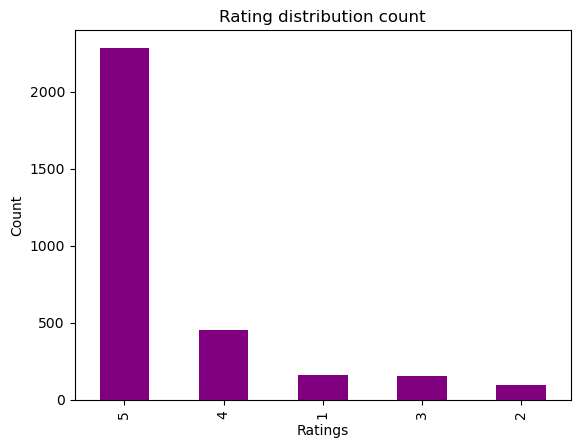

In [16]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = 'Purple')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

#### Analyzing the 'feedback' column

In [18]:
#Distinct values of 'feedback' and its count 

print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


#### There are 2 distinct values of 'feedback' present i.e. 0 and 1. Let's see what kind of review each value corresponds to.

In [20]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [21]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


#### From the above 2 examples we can see that feedback 0 is "negative review" and 1 is "positive review".

#### Let's plot the feedback value count in a bar graph

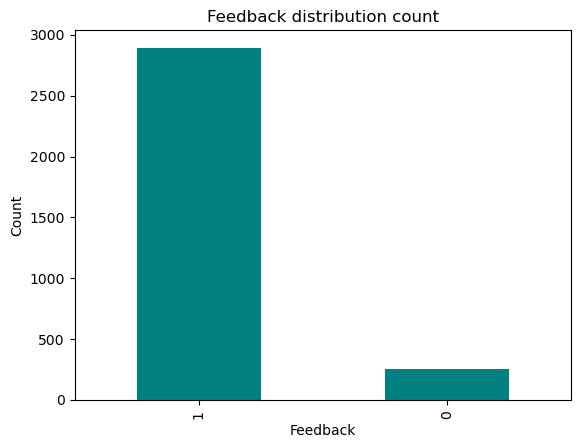

In [23]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = 'Teal')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

#### Let's see the 'rating' values for different values of 'feedback'

In [25]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [26]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

#### If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

### Preprocessing and Modelling
#### To build the corpus from the 'verified_reviews' we perform the following:
#### 1. Tokenization
#### 2. Converting to lower case
#### 3. Removing Stopwords
#### 4. Replace any non alphabet characters with a space
#### 5. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus.


In [29]:
STOPWORDS = set(stopwords.words('english'))
nltk.download('punkt')
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nabinagahatraj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
import torch

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report

In [133]:
# Convert star ratings to binary sentiment
def label_sentiment(rating):
    return 'Positive' if rating >= 3 else 'Negative'

data['sentiment'] = data['rating'].astype(int).apply(label_sentiment)


In [135]:
# function to assign ratings categories. 
#def label_sentiment(rating):
    #if rating <= 2:
        #return "Negative"
    #elif rating == 3:
        #return "Neutral"
    #else:
        #return "Positive"

#data["sentiment"] = data["rating"].apply(label_sentiment)


In [137]:
# Text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    tokens = word_tokenize(text)              #text tokenization
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

In [139]:
data['cleaned_text'] = data['verified_reviews'].apply(preprocess_text)    #storing the preprocessed text in a new column 'cleaned_text'


In [140]:
data.head()

,rating,date,variation,verified_reviews,feedback,sentiment,cleaned_text,sentiment_label
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,Positive,love echo,2
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,Positive,loved,2
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,Positive,sometimes playing game answer question correct...,2
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,Positive,lot fun thing yr old learns dinosaurs control ...,2
4,5,31-Jul-18,Charcoal Fabric,Music,1,Positive,music,2


In [145]:
# Convert labels to numbers
label_map = {"Negative": 0, "Positive": 1}
data["sentiment_label"] = data["sentiment"].map(label_map)

In [147]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['sentiment'], test_size=0.2, random_state=42, stratify=data['sentiment'])


In [149]:
from sklearn.feature_extraction.text import TfidfVectorizer   #To convert the text into numerical features for feeding to ML models

In [151]:
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [153]:
# Train Logistic Regression model
#Initialize the model
model = LogisticRegression()

#Train the model
model.fit(X_train_tfidf, y_train)


LogisticRegression()

In [155]:
# Making Predictions on test data
y_pred = model.predict(X_test_tfidf)


### Model Evaluation

In [158]:
# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.919047619047619
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        51
    Positive       0.92      1.00      0.96       579

    accuracy                           0.92       630
   macro avg       0.46      0.50      0.48       630
weighted avg       0.84      0.92      0.88       630



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### The Logistic Regression Model has Accuracy 0.87.


### Confusion Matrix

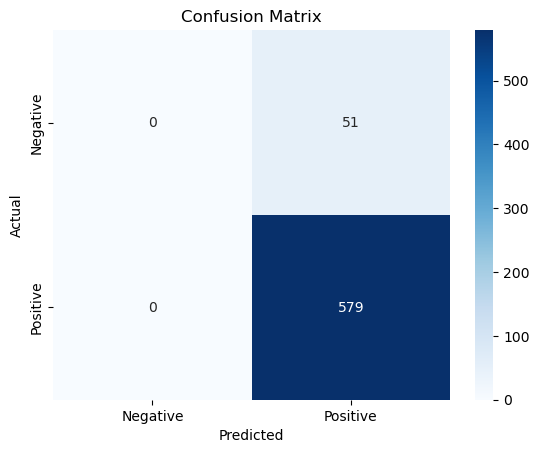

In [162]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Ploting the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Sentiment Distribution Plot

/var/folders/dl/4lcldw7n1gnbk9r573r1pvvm0000gn/T/ipykernel_84512/773136191.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['sentiment'], palette='coolwarm')


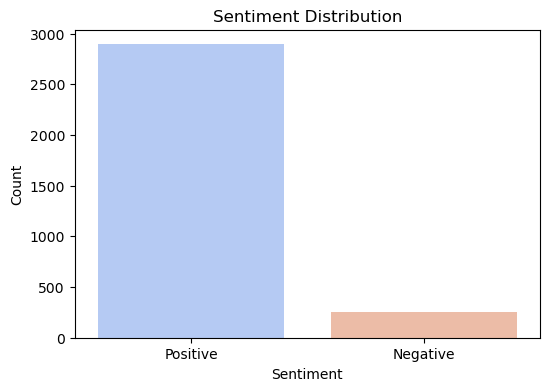

In [165]:
# Visualize sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=data['sentiment'], palette='coolwarm')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [167]:
#Testing with the new unseen text
# Test sentences
test_sentences = [
    "I am really satisfied with the product",
    "I am totally disappointed with this product",
    "I am happy with my purchase"
]

In [175]:
for sentence in test_sentences:
    cleaned_text = preprocess_text(sentence)
    features = vectorizer.transform([cleaned_text]) # vectorizing
    
    predicted_label = model.predict(features)
    predicted_sentiment = [predicted_label[0]]

    print(f"Sentence: '{sentence}' => Predicted Sentiment: {predicted_sentiment}")
    

Sentence: 'I am really satisfied with the product' => Predicted Sentiment: ['Positive']
Sentence: 'I am totally disappointed with this product' => Predicted Sentiment: ['Positive']
Sentence: 'I am happy with my purchase' => Predicted Sentiment: ['Positive']
